In [1]:
import numpy as np
import pandas as pd
import csv
import re

PATH = "data/"
LOB_FOLDER = "LOBS/"
TAPES_FOLDER = "Tapes/"

In [2]:
def read_exchange_tape(filename):
    time = []
    price = []
    quantity = []
    with open(PATH + TAPES_FOLDER + filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            time.append(float(row[0]))
            price.append(float(row[1]))
            quantity.append(int(row[2]))
    data = {'time': time,
            'price': price,
            'quantity': quantity}
    df = pd.DataFrame(data)
    return df

def read_exchange_LOB(filename):
    df = pd.read_table(PATH + LOB_FOLDER + filename, header=None, lineterminator='\n')
    df = df.to_numpy()
    time_list = []
    bids_list = []
    asks_list = []
    for i in range(df.shape[0]):
        curr = df[i][0]
        re_parse_num = r'[0-9]*[.]?[0-9]+'
        idx_time = curr.find('Exch0')
        idx_bid = curr.find('bid')
        idx_ask = curr.find('ask')
        time_segment = curr[0:idx_time]
        bid_segment = curr[idx_bid:idx_ask]
        ask_segment = curr[idx_ask:]
        time = float(re.findall(re_parse_num, time_segment)[0])
        time_list.append(time)
        res_bids = re.findall(re_parse_num, bid_segment)
        bids = []
        tmp = []
        for r in res_bids:
            tmp.append(int(r))
            if len(tmp) == 2:
                bids.append(tmp)
                tmp = []
        bids_list.append(bids)
        res_asks = re.findall(re_parse_num, ask_segment)
        asks = []
        tmp = []
        for r in res_asks:
            tmp.append(int(r))
            if len(tmp) == 2:
                asks.append(tmp)
                tmp = []
        asks_list.append(asks)
    data = {'time': time_list,
            'bids': bids_list,
            'asks': asks_list}
    df = pd.DataFrame(data)
    return df

In [3]:
df_tape = read_exchange_tape('UoB_Set01_2024-01-02tapes.csv')
print(df_tape)

df_LOB = read_exchange_LOB('UoB_Set01_2024-01-02LOBs.txt')
print(df_LOB)

            time  price  quantity
0          8.494  239.0         2
1          8.494  243.0         4
2          9.300  241.0         4
3         14.074  246.0         1
4         15.283  244.0         5
...          ...    ...       ...
25178  30599.263  266.0         2
25179  30599.263  267.0         2
25180  30599.263  268.0         3
25181  30599.263  272.0         1
25182  30599.263  277.0         2

[25183 rows x 3 columns]
             time                                               bids  \
0           0.000                                                 []   
1           0.093                                                 []   
2           1.240                                                 []   
3           2.542                                           [[1, 6]]   
4           2.666                                           [[1, 6]]   
...           ...                                                ...   
333591  30599.604  [[265, 6], [260, 8], [257, 7], [89, 1], [73

In [4]:
def preprocess_LOB_data(df):
    avg_bid_price = []
    avg_ask_price = []
    sum_bid_price = []
    sum_ask_price = []
    diff_bid_price = []
    diff_ask_price = []
    max_bid_price = []
    min_bid_price = []
    max_ask_price = []
    min_ask_price = []
    max_bid_volumn = []
    min_ask_volumn = []
    mid_price = []
    weighted_mid_price = []
    imbalance = []
    spread = []
    bid_level = []
    ask_level = []
    bids_list = df.bids.to_numpy()
    asks_list = df.asks.to_numpy()
    assert len(bids_list) == len(asks_list) 
    for bids in bids_list:
        if not bids:
            max_bid_price.append(0)
            max_bid_volumn.append(0)
            avg_bid_price.append(0)
        else:
            max_bid = max([b[0] for b in bids])
            max_bid_price.append(max_bid)
            max_bid_volumn.append(sum([b[1] for b in bids if b[0] == max_bid]))
            avg_bid_price.append(sum(b[0] * b[1] for b in bids) / sum(b[1] for b in bids))
        bid_level.append(len(bids))
#         sum_bid_price.append(sum(b[0] * b[1] for b in bids))
    for asks in asks_list:
        if not asks:
            min_ask_price.append(0)
            min_ask_volumn.append(0)
            avg_ask_price.append(0)
        else:
            min_ask = min([a[0] for a in asks])
            min_ask_price.append(min_ask)
            min_ask_volumn.append(sum([a[1] for a in asks if a[0] == min_ask]))
            avg_ask_price.append(sum(a[0] * a[1] for a in asks) / sum(a[1] for a in asks))
        ask_level.append(len(asks))
#         sum_ask_price.append(sum(a[0] * a[1] for a in asks))
    diff_bid_price = np.diff(avg_bid_price).tolist()
    diff_ask_price = np.diff(avg_ask_price).tolist()
    diff_bid_price.insert(0, 0.0)
    diff_ask_price.insert(0, 0.0)
    spread = np.array(min_ask_price) - np.array(max_bid_price)
    mid_price = (np.array(min_ask_price) + np.array(max_bid_price)) / 2
    #I = Qb / (Qa + Qb)
    imbalance = (np.array(max_bid_volumn) / (np.array(max_bid_volumn) + np.array(min_ask_volumn)))
    #Pb * (1 - I) + Pa * I
    weighted_mid_price = [max_bid_price[i] * (1 - imbalance[i]) + min_ask_price[i] * imbalance[i] for i in range(len(imbalance))]
    df['max_bid_price'] = max_bid_price
    df['min_ask_price'] = min_ask_price
    df['avg_bid_price'] = avg_bid_price
    df['avg_ask_price'] = avg_ask_price
    df['diff_bid_price'] = diff_bid_price
    df['diff_ask_price'] = diff_ask_price
    df['bid_level'] = bid_level
    df['ask_level'] = ask_level
    df['spread'] = spread
    df['mid_price'] = mid_price
    df['weighted_mid_price'] = weighted_mid_price
    df['imbalance'] = imbalance
    df = df.fillna(0)
    return df

In [5]:
df_LOB = preprocess_LOB_data(df_LOB)
df_LOB.to_csv('cleaned_LOB.csv')  

/var/folders/s6/h3t7p24n40q8x3mfd_xnt_6w0000gn/T/ipykernel_30488/3074323608.py:54: RuntimeWarning: invalid value encountered in divide
  imbalance = (np.array(max_bid_volumn) / (np.array(max_bid_volumn) + np.array(min_ask_volumn)))


<AxesSubplot: xlabel='time'>

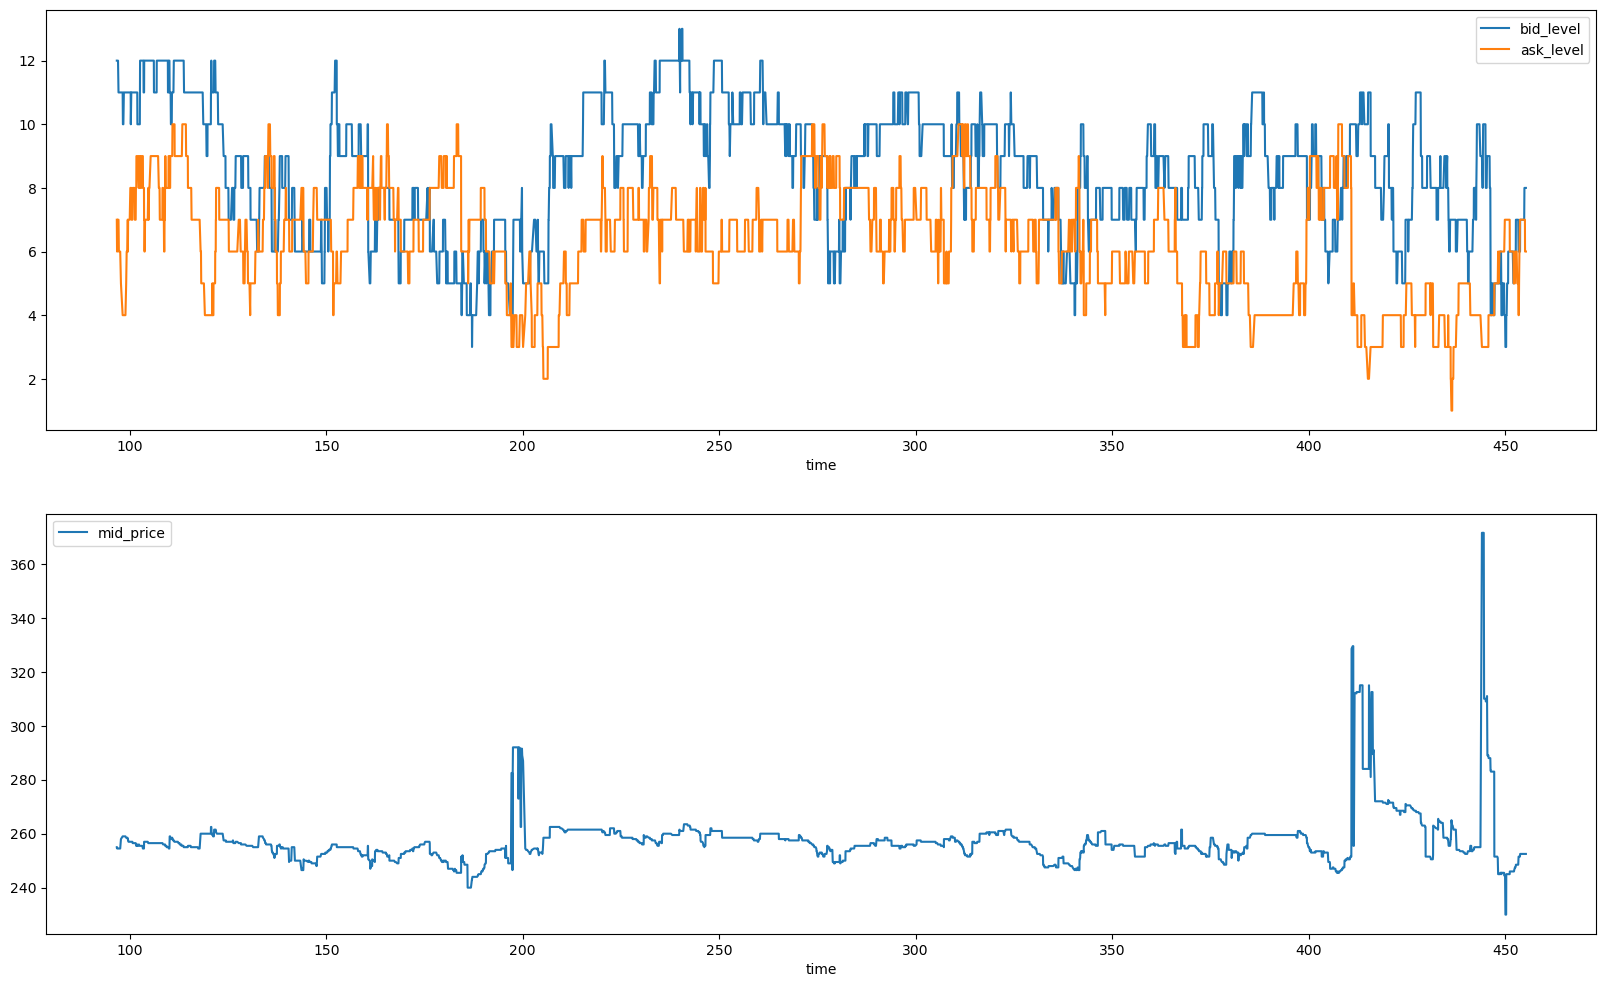

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,12)) 
df_LOB.iloc[1000:5000].plot(x='time', y='bid_level',ax = ax[0], kind='line')
df_LOB.iloc[1000:5000].plot(x='time', y='ask_level',ax = ax[0], kind='line')
df_LOB.iloc[1000:5000].plot(x='time', y='mid_price',ax = ax[1], kind='line')

In [7]:
mean_bid_level = np.mean(df_LOB.bid_level)
mean_ask_level = np.mean(df_LOB.ask_level)
max_bid_level = np.max(df_LOB.bid_level)
max_ask_level = np.max(df_LOB.ask_level)
print("mean_bid_level: {}\n\
mean_ask_level: {}\n\
max_bid_level: {}\n\
max_ask_level: {}\n".format(mean_bid_level, mean_ask_level, max_bid_level, max_ask_level))

mean_bid_level: 7.971546421419921
mean_ask_level: 5.906614587704889
max_bid_level: 15
max_ask_level: 13



<AxesSubplot: xlabel='time'>

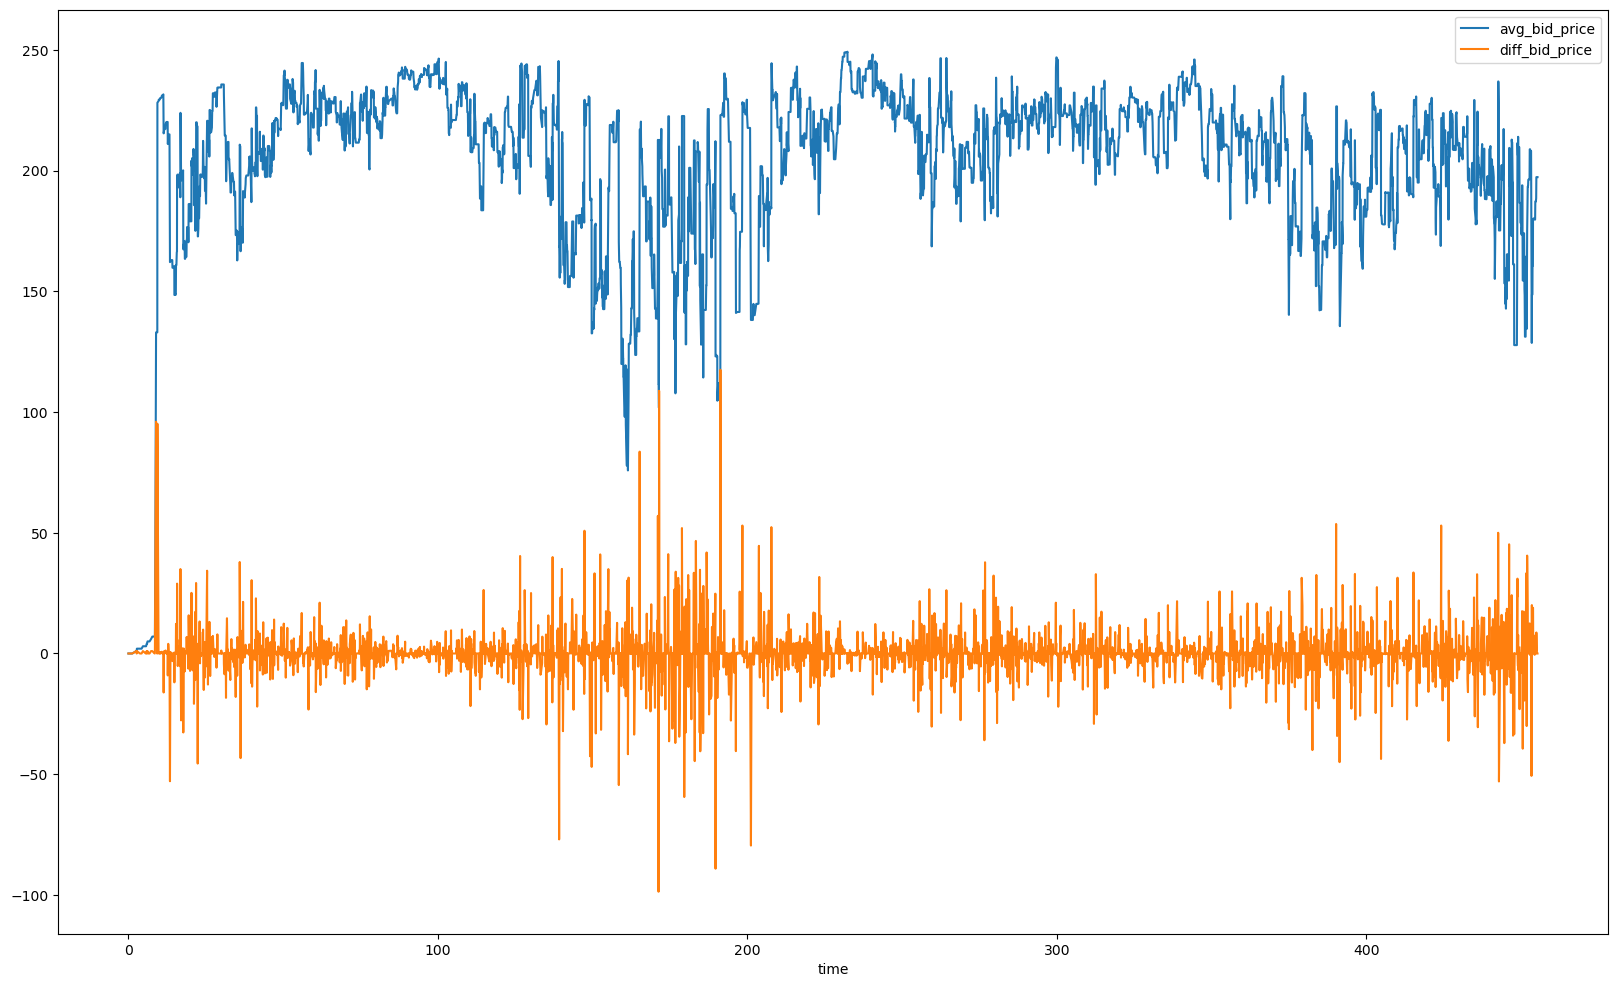

In [8]:
fig, ax = plt.subplots(figsize=(20,12)) 
df_LOB.iloc[:5000].plot(x='time', y='avg_bid_price',ax = ax, kind='line')
df_LOB.iloc[:5000].plot(x='time', y='diff_bid_price',ax = ax, kind='line')
# df_LOB.iloc[:5000].plot(x='time', y='avg_ask_price',ax = ax, kind='line')

<AxesSubplot: xlabel='time'>

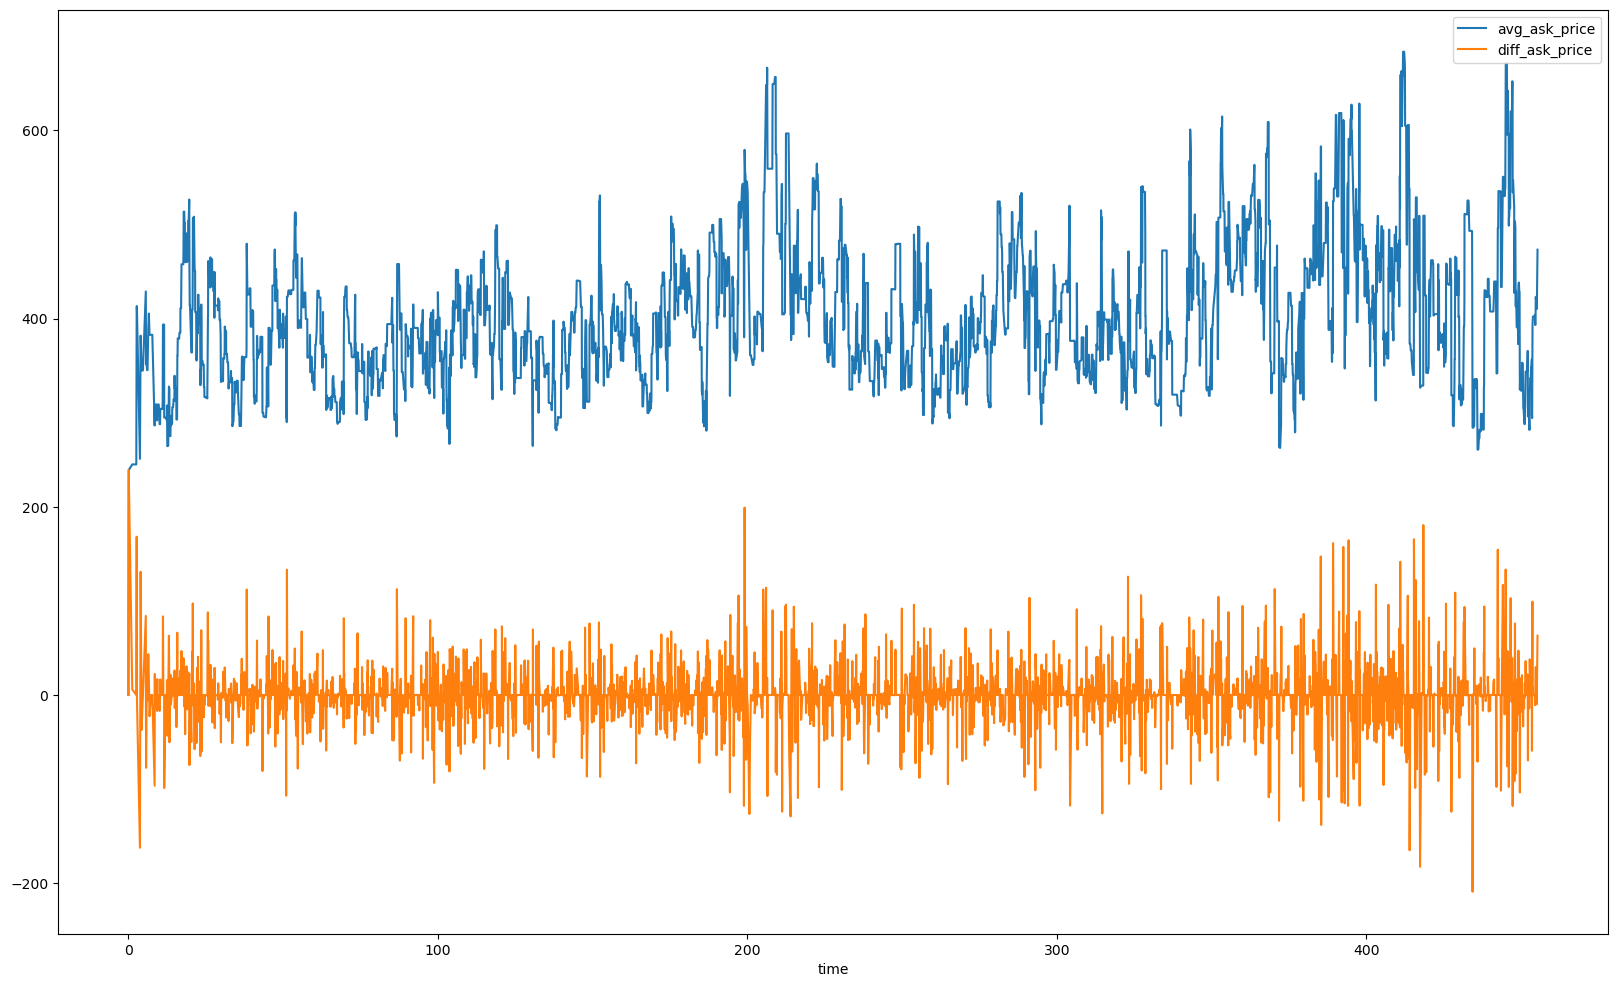

In [9]:
fig, ax = plt.subplots(figsize=(20,12)) 
df_LOB.iloc[:5000].plot(x='time', y='avg_ask_price',ax = ax, kind='line')
df_LOB.iloc[:5000].plot(x='time', y='diff_ask_price',ax = ax, kind='line')

<AxesSubplot: xlabel='time', ylabel='price'>

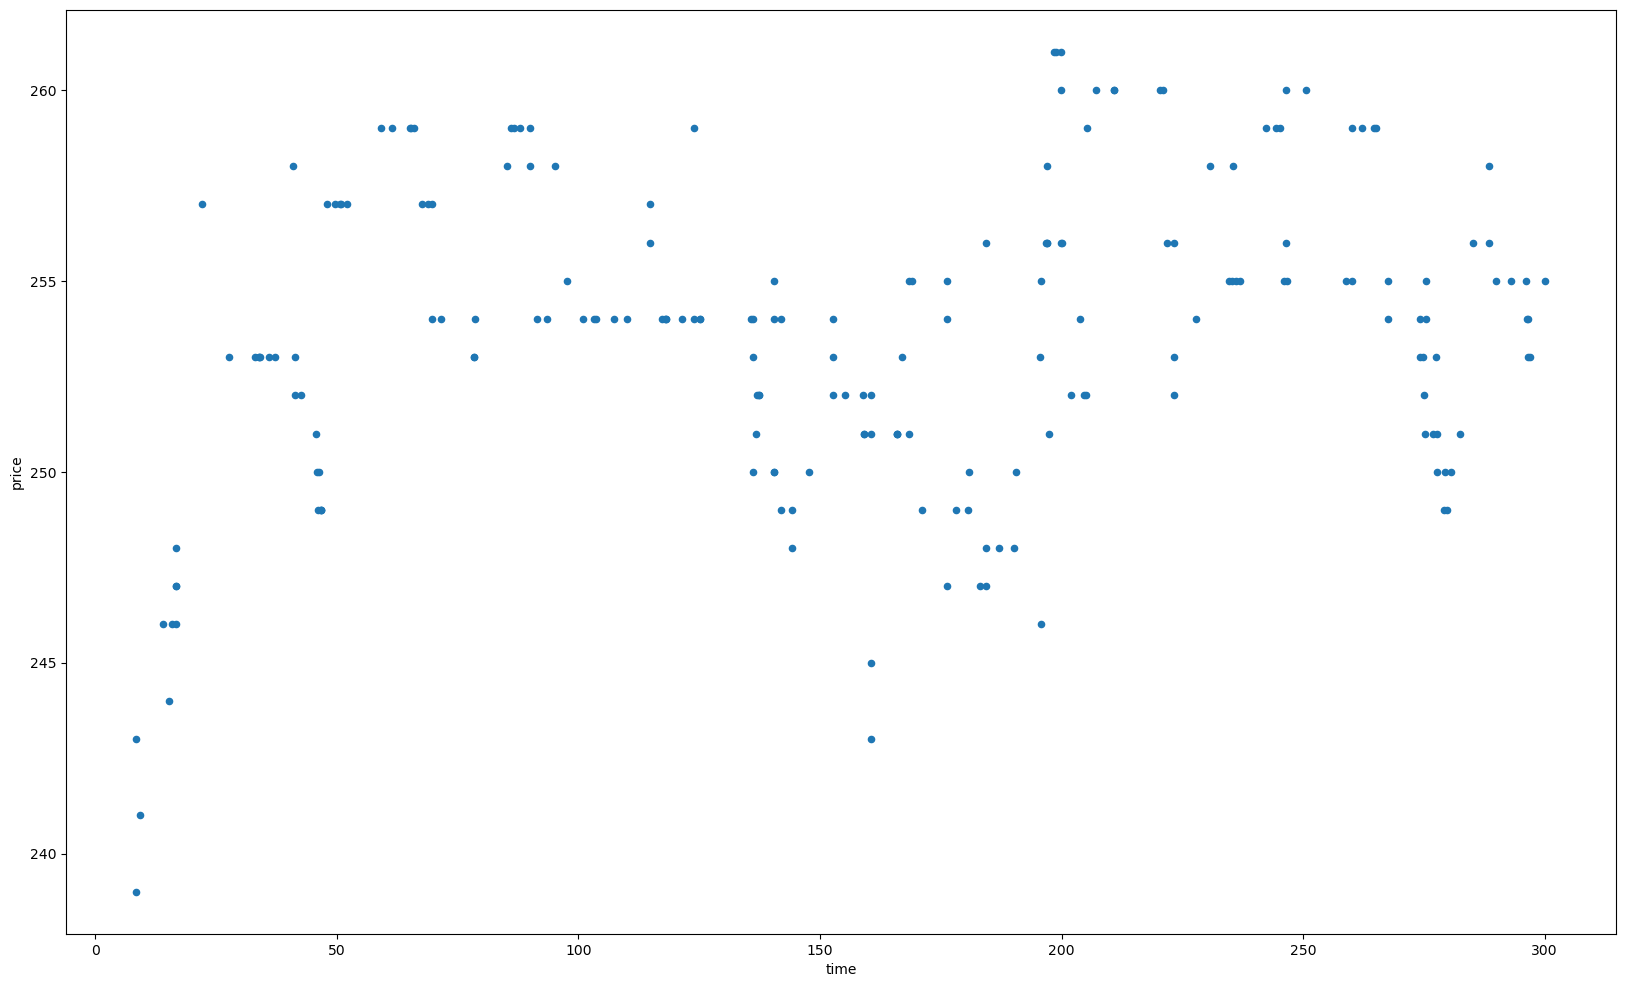

In [10]:
fig, ax = plt.subplots(figsize=(20,12)) 
df_tape.iloc[:200].plot(x='time', y='price',ax = ax, kind='scatter')

<AxesSubplot: xlabel='time'>

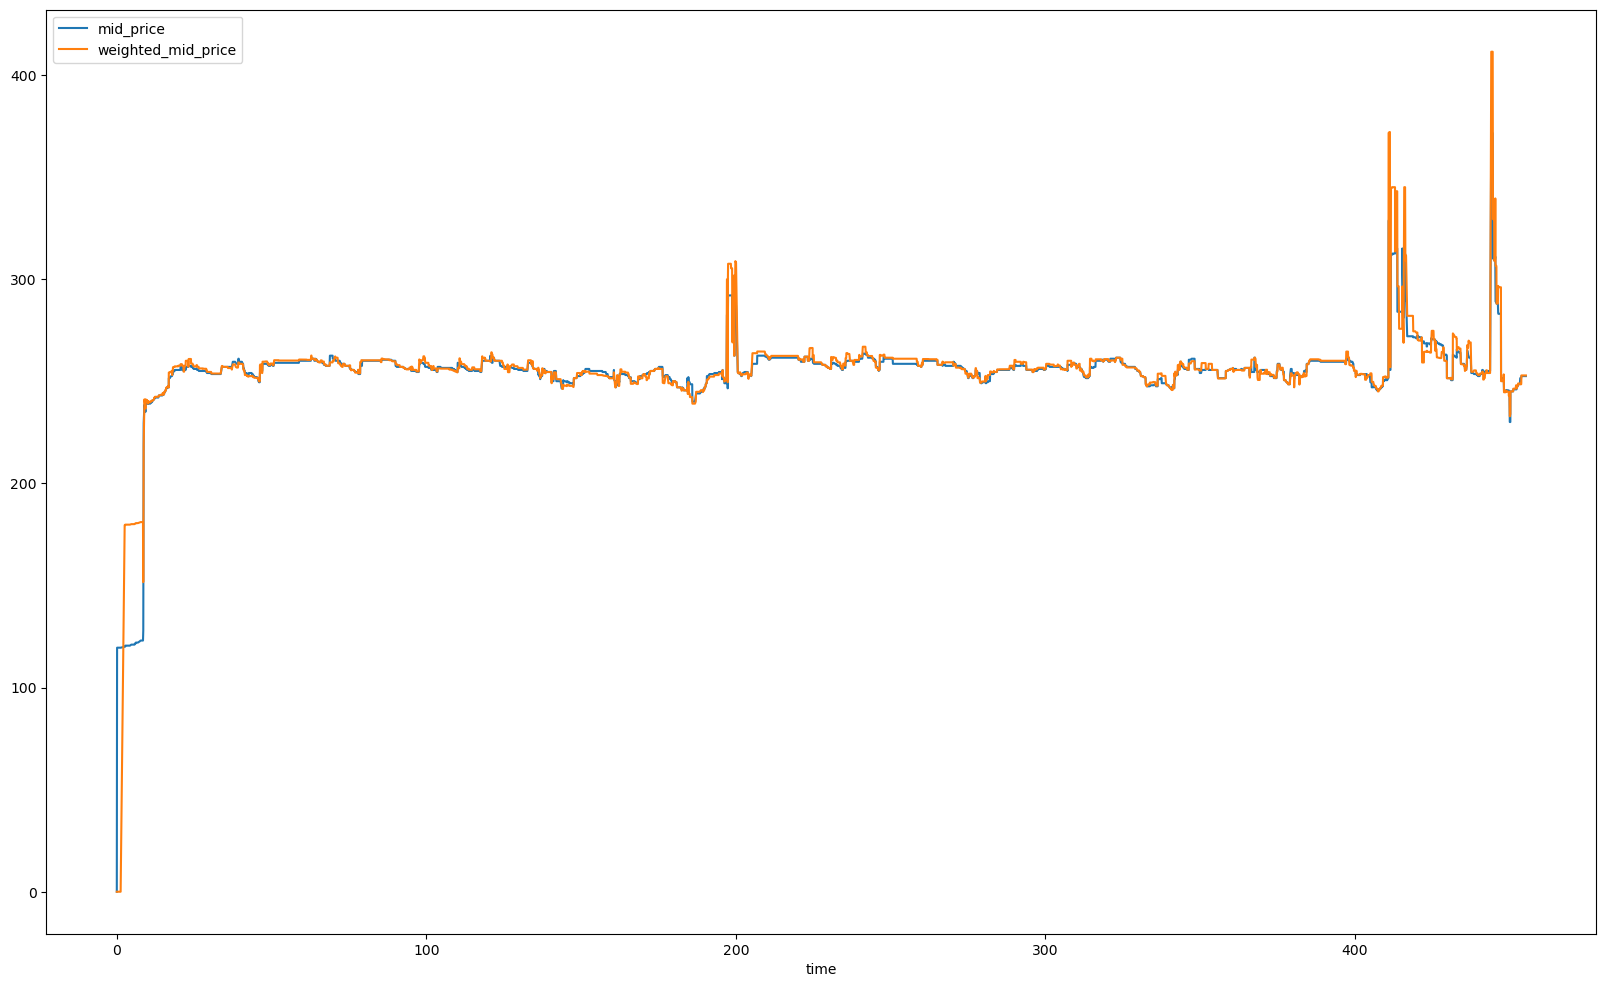

In [12]:
fig, ax = plt.subplots(figsize=(20,12)) 
df_LOB.iloc[:5000].plot(x='time', y='mid_price',ax = ax, kind='line')
df_LOB.iloc[:5000].plot(x='time', y='weighted_mid_price',ax = ax, kind='line')

In [12]:
import math
window_size = 10

def apply_slide_window(df, window_size):
    max_time = math.ceil(np.max(df['time']))
    time_slots = np.arange(0, max_time, window_size)
    mid_prices = []
    for i in range(len(time_slots) - 1):
        filtered = df[(df.time >= time_slots[i]) & (df.time < time_slots[i + 1])].mid_price
        mid_prices.append(np.mean(filtered))
    smoothed_data = {'price': mid_prices}
    return pd.DataFrame(data=smoothed_data)

df_smoothed = apply_slide_window(df_LOB, window_size)

train_size = int(len(df_smoothed) * 0.70)
test_size = len(df_smoothed) - train_size

train_data = df_smoothed[:train_size]
test_data = df_smoothed[train_size:train_size+test_size]

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/zepingchen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


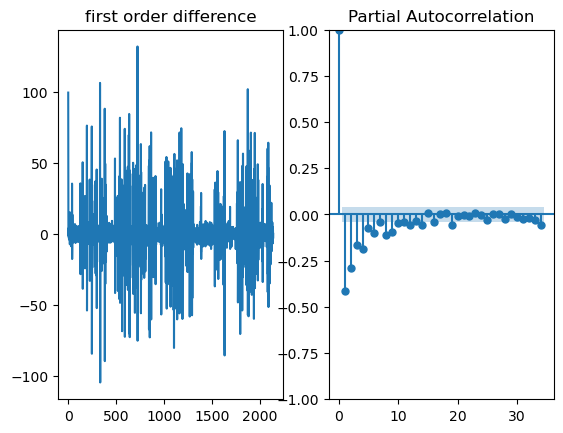

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("first order difference")
ax1.plot(train_data.diff())

ax2 = fig.add_subplot(122)
ax2.set_title("first order partialcorrelation")
plot_pacf(train_data.diff().dropna(), ax=ax2)
plt.show()

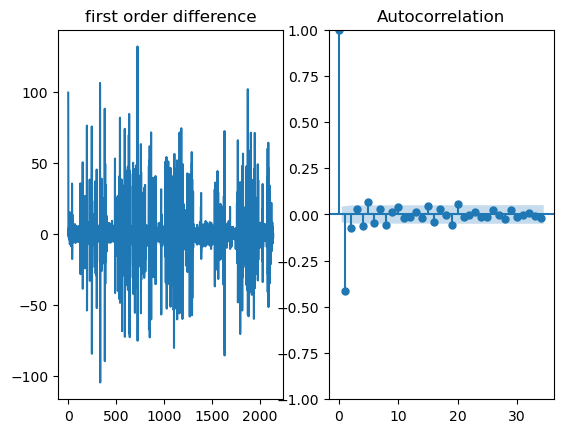

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("first order difference")
ax1.plot(train_data.diff())

ax2 = fig.add_subplot(122)
ax2.set_title("first order autocorrelation")
plot_acf(train_data.diff().dropna(), ax=ax2)
plt.show()

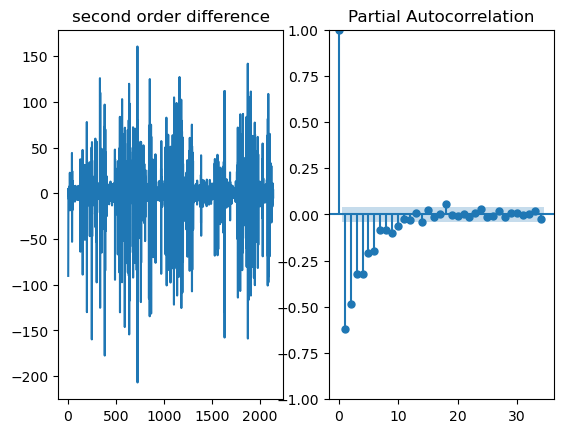

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("second order difference")
ax1.plot(train_data.diff().diff())

ax2 = fig.add_subplot(122)
ax2.set_title("second order partialcorrelation")
plot_pacf(train_data.diff().diff().dropna(), ax=ax2)
plt.show()

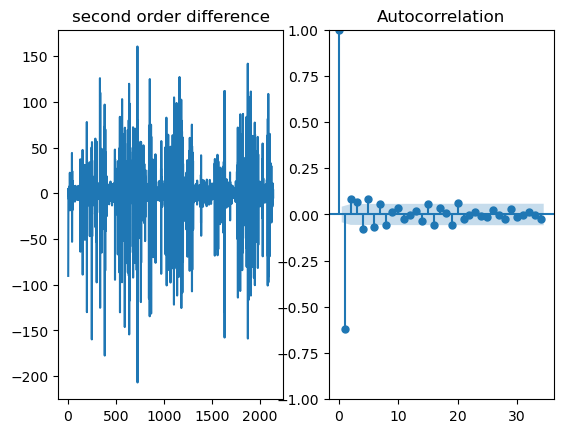

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.set_title("second order difference")
ax1.plot(train_data.diff().diff())

ax2 = fig.add_subplot(122)
ax2.set_title("second order autocorrelation")
plot_acf(train_data.diff().diff().dropna(), ax=ax2)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data)
print("P-value: {}".format(result[1]))
result = adfuller(train_data.diff().dropna())
print("P-value: {}".format(result[1]))
result = adfuller(train_data.diff().diff().dropna())
print("P-value: {}".format(result[1]))

P-value: 1.7650463554229885e-06
P-value: 2.1488180315896296e-29
P-value: 2.137761626069616e-30


In [19]:
import pmdarima as pm

auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
print(auto_arima)

 ARIMA(2,1,3)(0,0,0)[0] intercept


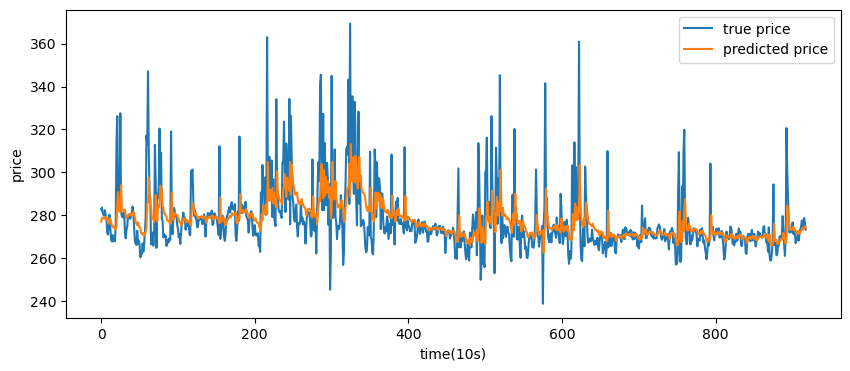

In [20]:
import time

history = train_data.to_numpy().reshape(-1).tolist()
true_values = test_data.to_numpy().reshape(-1).tolist()
predictions = []
start_time = time.time()
for i in range(test_size):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    next_prediction = model_fit.forecast(steps=1)[0]
    predictions.append(next_prediction)
    history.append(true_values[i])
#     print("prediction time: {}".format(time.time() - start_time))
#     start_time = time.time()
xs = np.arange(len(predictions))
fig, ax = plt.subplots(figsize=(10, 4)) 
plt.plot(xs, true_values, label='true price')
plt.plot(xs, predictions, label='predicted price')
plt.xlabel("time(10s)")
plt.ylabel("price")
plt.legend()

In [21]:
error = sum([(true_values[i] - predictions[i])**2 for i in range(len(predictions))])
print("error: {}".format(error))

error: 159567.15346982202


In [37]:
def run_simulation(prices, returns, verbose=False, plot=False):
    
    curr_holding = False
    buy_history = []
    sell_history = []
    profit_history = []
    total_profit = 0
    
    for i in range(100, len(prices)):
    
        curr_data = prices[:i]
        
        try:
            model = ARIMA(curr_data, order=(1,1,1))
            model_fit = model.fit()
            next_prediction = model_fit.forecast(steps=1)[0]
        except:
            raise Exception("failed to train ARIMA model")

        if not curr_holding:
            if next_prediction > np.mean(curr_data[-3:]):
                ##buy when the next predicted price is higher than the mean of the previous three prices 
                buy_price = curr_data[-1]
                buy_history.append(buy_price)
                curr_holding = True
                if verbose:
                    print("Buy with price {}".format(buy_price))
                    
        else:
            if next_prediction < np.mean(curr_data[-3:]):
                ##sell when the next predicted price is lower than the mean of the previous three prices 
                sell_price = curr_data[-1]
                if sell_price > buy_price:
                    sell_history.append(sell_price)
                    profit_history.append(sell_price - buy_price)
                    total_profit += sell_price - buy_price
                    curr_holding = False
                    if verbose:
                        print("Sell with price {}, gain {} profit ".format(sell_price, sell_price - buy_price))
                else:
                    if np.random.rand() > 0.5:
                        sell_history.append(sell_price)
                        profit_history.append(sell_price - buy_price)
                        total_profit += sell_price - buy_price
                        curr_holding = False
                        if verbose:
                            print("Sell with price {}, gain {} profit ".format(sell_price, sell_price - buy_price))
                
    print(len(buy_history))
    print(len(sell_history))
    print(len(profit_history))
    
    print("total_profit: {}".format(total_profit))
    
    if plot:
        pass
    
    return total_profit


In [38]:
profit = run_simulation(prices, returns, verbose=True)


Buy with price 260.6302521008403
Sell with price 252.2280701754386, gain -8.40218192540172 profit 
Buy with price 257.75
Sell with price 258.60357142857146, gain 0.8535714285714562 profit 
Buy with price 261.4403669724771
Sell with price 260.135, gain -1.3053669724770884 profit 
Buy with price 262.8551401869159
Sell with price 262.2803738317757, gain -0.5747663551401843 profit 
Buy with price 265.62820512820514
Sell with price 261.17905405405406, gain -4.449151074151075 profit 
Buy with price 285.68
Sell with price 257.88793103448273, gain -27.792068965517274 profit 
Buy with price 254.43076923076924
Sell with price 255.58467741935485, gain 1.1539081885856035 profit 
Buy with price 259.33490566037733
Sell with price 259.7226890756302, gain 0.3877834152528976 profit 
Buy with price 262.2314049586777
Sell with price 259.26691729323306, gain -2.964487665444608 profit 
Buy with price 250.8815789473684
Sell with price 244.25590551181102, gain -6.625673435557388 profit 
Buy with price 245.35

/Users/zepingchen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Sell with price 271.5, gain -23.730000000000018 profit 
Buy with price 265.5233644859813
Sell with price 268.57608695652175, gain 3.052722470540459 profit 
Buy with price 270.099173553719
Sell with price 266.9736842105263, gain -3.1254893431927258 profit 
Buy with price 263.28712871287127
Sell with price 289.3529411764706, gain 26.065812463599343 profit 
Buy with price 272.6629213483146
Sell with price 272.0570175438597, gain -0.6059038044549538 profit 
Buy with price 315.9347826086956
Sell with price 263.7197802197802, gain -52.21500238891542 profit 
Buy with price 263.84
Sell with price 264.6643356643357, gain 0.824335664335706 profit 
Buy with price 265.2983870967742
Sell with price 246.63372093023256, gain -18.66466616654165 profit 
Buy with price 352.77840909090907
Sell with price 373.4761904761905, gain 20.697781385281417 profit 
Buy with price 264.70982142857144
Sell with price 269.23275862068965, gain 4.522937192118206 profit 
Buy with price 261.24311926605503
Sell with price 2

Buy with price 305.4
Sell with price 309.7549019607843, gain 4.354901960784332 profit 
Buy with price 284.2383177570093
Sell with price 285.3670212765957, gain 1.128703519586395 profit 
Buy with price 318.51063829787233
Sell with price 290.9102564102564, gain -27.600381887615924 profit 
Buy with price 273.3489583333333
Sell with price 310.25, gain 36.901041666666686 profit 
Buy with price 265.78512396694214
Sell with price 279.48275862068965, gain 13.697634653747514 profit 
Buy with price 268.9516129032258
Sell with price 325.1868131868132, gain 56.2352002835874 profit 
Buy with price 273.2352941176471
Sell with price 268.4901960784314, gain -4.745098039215691 profit 
Buy with price 268.1261261261261
Sell with price 284.9330357142857, gain 16.806909588159613 profit 
Buy with price 255.34375
Sell with price 291.70108695652175, gain 36.35733695652175 profit 
Buy with price 274.7669902912621
Sell with price 270.5326086956522, gain -4.234381595609932 profit 
Buy with price 268.766666666666

Buy with price 278.16964285714283
Sell with price 276.0164835164835, gain -2.153159340659329 profit 
Buy with price 274.2964285714286
Sell with price 280.6991525423729, gain 6.402723970944294 profit 
Buy with price 271.53061224489795
Sell with price 273.60550458715596, gain 2.0748923422580106 profit 
Buy with price 268.4260869565217
Sell with price 313.74074074074076, gain 45.31465378421905 profit 
Buy with price 278.9362745098039
Sell with price 283.9952380952381, gain 5.058963585434185 profit 
Buy with price 267.53508771929825
Sell with price 317.12254901960785, gain 49.5874613003096 profit 
Buy with price 270.029702970297
Sell with price 296.5515463917526, gain 26.52184342145557 profit 
Buy with price 289.8835616438356
Sell with price 292.9854368932039, gain 3.101875249368277 profit 
Buy with price 269.51801801801804
Sell with price 279.5154639175258, gain 9.997445899507738 profit 
Buy with price 278.3385416666667
Sell with price 281.375, gain 3.0364583333333144 profit 
Buy with pri

In [27]:
EMA_LENGTH = 20
previous_ema = None

def calculate_sma(prices, length=20):
    return np.mean(prices[:length])

def calculate_ema(prices, idx, length=20):
    global previous_ema
    if previous_ema == None:
        ema = calculate_sma(prices, length=length)
        previous_ema = ema
        return ema
    else:
        multiplier = 1 / (length + 1)
        ema = prices[idx] * multiplier + previous_ema * (1 - multiplier)
        previous_ema = ema
        return ema
    
def get_ema_list(prices, length=20):
    global previous_ema
    previous_ema = None
    ema_prices = []
    for i in range(len(prices) - length):
        ema = calculate_ema(prices, i + length, length=length)
        ema_prices.append(ema)
    return ema_prices

# prices = train_data['price']
df_smoothed = apply_slide_window(df_LOB, window_size)
prices = df_smoothed['price'].to_numpy().tolist()

3033
3033
3059


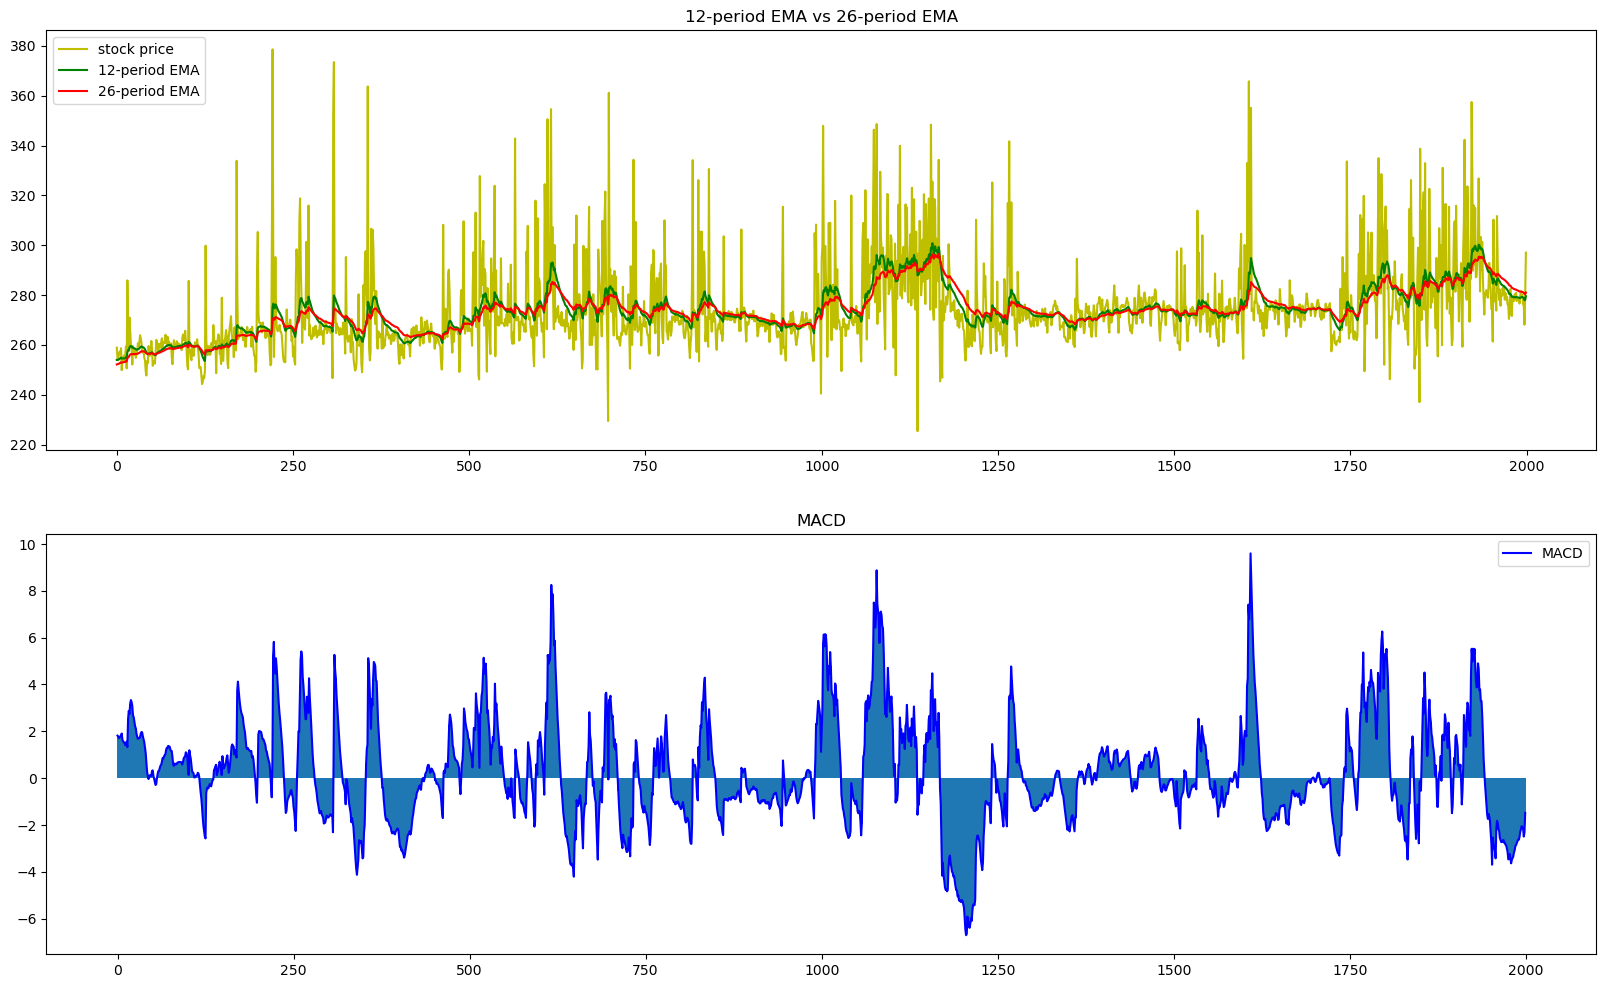

In [33]:
# MACD= 12-Period EMA − 26-Period EMA
ema_prices_12 = get_ema_list(prices, length=12)
ema_prices_26 = get_ema_list(prices, length=26)
ema_prices_12 = ema_prices_12[-len(ema_prices_26):] 
# ema_prices_12 = ema_prices_12[:len(ema_prices_26)] 

macd = np.subtract(ema_prices_12, ema_prices_26)

display_size = 2000
print(len(ema_prices_26))
print(len(ema_prices_12))
print(len(prices))

offset = len(prices) - len(ema_prices_26)
fig, ax = plt.subplots(2, 1, figsize=(20,12)) 
ax[0].set_title("12-period EMA vs 26-period EMA")
# ax[0].plot(prices[-len(ema_prices_26):], color='y', label='stock price')
ax[0].plot(prices[offset:display_size+offset], color='y', label='stock price')
ax[0].plot(ema_prices_12[:display_size], color='g', label='12-period EMA')
ax[0].plot(ema_prices_26[:display_size], color='r', label='26-period EMA')
ax[0].legend()
ax[1].set_title("MACD")
ax[1].plot(macd[:display_size], color='b', label='MACD')
ax[1].bar(np.arange(0, display_size, 1), height=macd[:display_size], width=2)
ax[1].legend()

In [ ]:
def run_simulation_new(prices, returns, verbose=False, plot=False):
    
    curr_holding = False
    buy_history = []
    sell_history = []
    profit_history = []
    total_profit = 0
    
    for i in range(100, len(prices)):
        
        curr_data = prices[:i]
        curr_macd = macd[:i-26]
        
        try:
            model = ARIMA(curr_data, order=(1,1,1))
            model_fit = model.fit()
            next_prediction = model_fit.forecast(steps=1)[0]
        except:
            raise Exception("failed to train ARIMA model")
        if not curr_holding:
            if next_prediction > np.mean(curr_data[-3:]) or np.mean(curr_macd[-3:]) < 0:
                ##buy when the next predicted price is higher than the mean of the previous three prices 
                buy_price = curr_data[-1]
                buy_history.append(buy_price)
                curr_holding = True
                if verbose:
                    print("Buy with price {}".format(buy_price))
                    
        else:
            if next_prediction < np.mean(curr_data[-3:]) or np.mean(curr_macd[-3:]) > 0:
                ##sell when the next predicted price is lower than the mean of the previous three prices 
                sell_price = curr_data[-1]
                if sell_price > buy_price:
                    sell_history.append(sell_price)
                    profit_history.append(sell_price - buy_price)
                    total_profit += sell_price - buy_price
                    curr_holding = False
                    if verbose:
                        print("Sell with price {}, gain {} profit ".format(sell_price, sell_price - buy_price))
                else:
                    if np.random.rand() > 0.5:
                        sell_history.append(sell_price)
                        profit_history.append(sell_price - buy_price)
                        total_profit += sell_price - buy_price
                        curr_holding = False
                        if verbose:
                            print("Sell with price {}, gain {} profit ".format(sell_price, sell_price - buy_price))
                
    print(len(buy_history))
    print(len(sell_history))
    print(len(profit_history))
    
    print("total_profit: {}".format(total_profit))
    
    if plot:
        pass
    
    return total_profit

In [260]:
profit = run_simulation(prices, returns, verbose=True)

Buy with price 264.1
Sell with price 327.0773381294964, gain 62.97733812949639 profit 
Buy with price 265.07142857142856
Sell with price 291.41339869281046, gain 26.341970121381905 profit 
Buy with price 263.63947368421054
Sell with price 265.0558823529412, gain 1.4164086687306394 profit 
Buy with price 263.5828125
Sell with price 268.6311239193084, gain 5.048311419308391 profit 
Buy with price 266.67906336088157
Sell with price 287.9555555555556, gain 21.276492194674006 profit 
Buy with price 264.11876832844575
Sell with price 284.4598853868195, gain 20.341117058373754 profit 
Buy with price 271.9172932330827
Sell with price 278.36544850498336, gain 6.448155271900646 profit 
Buy with price 277.89627659574467
Sell with price 281.8160237388724, gain 3.919747143127722 profit 
Buy with price 262.2053824362606
Sell with price 280.9972067039106, gain 18.791824267649986 profit 
Buy with price 262.52721088435374
Sell with price 297.6411764705882, gain 35.113965586234485 profit 
Buy with price

Buy with price 269.7931034482759
Sell with price 257.6159217877095, gain -12.177181660566362 profit 
Buy with price 285.8636363636364
Sell with price 300.0683890577508, gain 14.204752694114404 profit 
Buy with price 269.66838487972507
Sell with price 270.6797583081571, gain 1.011373428432023 profit 
Buy with price 272.1987767584098
Sell with price 269.62533333333334, gain -2.573443425076448 profit 
Buy with price 269.57278481012656
Sell with price 269.73064516129034, gain 0.1578603511637766 profit 
Buy with price 260.1170520231214
Sell with price 264.55409356725147, gain 4.437041544130068 profit 
Buy with price 269.88088235294117
Sell with price 265.59620991253644, gain -4.284672440404734 profit 
Buy with price 301.24679487179486
Sell with price 271.6835443037975, gain -29.563250567997386 profit 
Buy with price 270.59659090909093
92
91
91
total_profit: 767.1398366073345
